# QAOA - quTip version

## Preamble & modules

In [ ]:
# IPython.Application.instance().kernel.do_shutdown(True)

In [1]:
%matplotlib inline

import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
# import datetime as dt
# import os

import itertools as itt

from tqdm import tqdm

import networkx as nx

from qutip_qip.operations import gate_sequence_product, snot, rx, ry, rz, qrot
from qutip_qip.circuit import QubitCircuit, Gate
from IPython.display import Image

import sys

## System parameters

In [2]:
# sys_dims = [2,2,2,2,2,2,2]
# num_qubits = len(sys_dims)

sys_dims = [2,2,2,2]
num_qubits = len(sys_dims)

In [3]:
# graph = [(i, i+1) for i in range(6)]
# print(graph)

graph = [(i, i+1) for i in range(num_qubits-1)]
print(graph)

[(0, 1), (1, 2), (2, 3)]


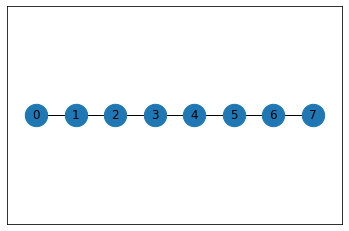

In [4]:
G = nx.DiGraph()
G.add_edges_from([('0', '1'), ('1', '2'), ('2', '3'), ('3', '4'), ('4', '5'), ('5', '6'), ('6', '7')])

positions = {'0': [0,0], '1': [1,0], '2': [2,0], '3': [3,0], '4': [4,0], '5': [5,0], '6': [6,0], '7': [7,0]}

nx.draw_networkx_nodes(G, pos = positions, node_size = 500)
nx.draw_networkx_labels(G, pos = positions)
nx.draw_networkx_edges(G, pos = positions, arrows=False)
plt.show()

In [5]:
psi0 = qt.basis(sys_dims, [0]*num_qubits)

## Gates

Qubits are numbered from left to right (like is the convention in most of the literature, but not the convention that Rigetti adopts). So, in |i1, i2, ..., in >, i1 is the 0'th qubit, i2 the 1st qubit, etc. (*NOTE: I should maybe change this convention later*).

In [ ]:
# q = QubitCircuit(3, reverse_states=False)
# q.add_gate("CNOT", controls=[0], targets=[2])

# q.png

In [6]:
def hadamard(list_of_qubits):
    # list must be integer positions of qubits to which
    # you wish to apply a hadamard
    had_list = []
    for i in range(num_qubits):
        if i in list_of_qubits:
            had_list.append(snot())
        else:
            had_list.append(qt.qeye(2))
    return qt.tensor(had_list)

In [7]:
def sigmaZ(list_of_qubits):
    # list must be integer positions of qubits to which
    # you wish to apply the sigma Z operation
    sigmaZ_list = []
    for i in range(num_qubits):
        if i in list_of_qubits:
            sigmaZ_list.append(qt.sigmaz())
        else:
            sigmaZ_list.append(qt.qeye(2))
    return qt.tensor(sigmaZ_list)

def sigmaY(list_of_qubits):
    # list must be integer positions of qubits to which
    # you wish to apply the sigma Y operations
    sigmaY_list = []
    for i in range(num_qubits):
        if i in list_of_qubits:
            sigmaY_list.append(qt.sigmay())
        else:
            sigmaY_list.append(qt.qeye(2))
    return qt.tensor(sigmaY_list)

def sigmaX(list_of_qubits):
    # list must be integer positions of qubits to which
    # you wish to apply the sigma X operations
    sigmaX_list = []
    for i in range(num_qubits):
        if i in list_of_qubits:
            sigmaX_list.append(qt.sigmax())
        else:
            sigmaX_list.append(qt.qeye(2))
    return qt.tensor(sigmaX_list)

Note: take care with qubit angles below. Sohaib defines the R_z(\phi) gate as ((e^{-i*\phi}, 0), (0, e^{i*\phi})), whereas rz, in qutip, is rz(\phi) = ((e^{-i*\phi/2}, 0), (0, e^{i*\phi/2})). The same holds for R_x and R_y, and I've hence changed my definitions below to match Sohaib's.

In [8]:
def rotateZ(dict_of_qubit_angles):
    # dictionary must be one with qubits, as integers, as the
    # keys and angles as numpy object in radians. Be careful with angles!
    rotateZ_list = []
    for i in range(num_qubits):
        if i in list(dict_of_qubit_angles.keys()):
            rotateZ_list.append(rz(2*dict_of_qubit_angles[i]))
        else:
            rotateZ_list.append(qt.qeye(2))
    return qt.tensor(rotateZ_list)

def rotateX(dict_of_qubit_angles):
    # dictionary must be one with qubits, as integers, as the
    # keys and angles as numpy object in radians. Be careful with angles!
    rotateX_list = []
    for i in range(num_qubits):
        if i in list(dict_of_qubit_angles.keys()):
            rotateX_list.append(rx(2*dict_of_qubit_angles[i]))
        else:
            rotateX_list.append(qt.qeye(2))
    return qt.tensor(rotateX_list)

def rotateY(dict_of_qubit_angles):
    # dictionary must be one with qubits, as integers, as the
    # keys and angles as numpy object in radians. Be careful with angles!
    rotateY_list = []
    for i in range(num_qubits):
        if i in list(dict_of_qubit_angles.keys()):
            rotateY_list.append(ry(2*dict_of_qubit_angles[i]))
        else:
            rotateY_list.append(qt.qeye(2))
    return qt.tensor(rotateY_list)

In [9]:
def projector_ground(list_of_qubits):
    # list must be integer positions of qubits to which
    # you wish to apply the ground state projector |0><0|
    grnd_list = []
    grnd_proj = qt.Qobj([[1, 0], [0, 0]])
    for i in range(num_qubits):
        if i in list_of_qubits:
            grnd_list.append(grnd_proj)
        else:
            grnd_list.append(qt.qeye(2))
    return qt.tensor(grnd_list)

def project_excited(list_of_qubits):
    # list must be integer positions of qubits to which
    # you wish to apply the excited state projector |1><1|
    excite_list = []
    excite_proj = qt.Qobj([[0, 0], [0, 1]])
    for i in range(num_qubits):
        if i in list_of_qubits:
            excite_list.append(excite_proj)
        else:
            excite_list.append(qt.qeye(2))
    return qt.tensor(excite_list)

In [10]:
def Cnot(control, target):
    # control and target must be integers referring to the control
    # and target qubits
    q = QubitCircuit(num_qubits, reverse_states=False)
    q.add_gate("CNOT", controls=[control], targets=[target])
    U_list = q.propagators()
    U = gate_sequence_product(U_list)
    return U

def Cz(control, target):
    # control and target must be integers referring to the control
    # and target qubits
    q = QubitCircuit(num_qubits, reverse_states=False)
    q.add_gate("CZ", controls=[control], targets=[target])
    U_list = q.propagators()
    U = gate_sequence_product(U_list)
    return U

## Sanity check: get the landscape by manually exponentiating the gates (this is similar to the way one would write pyquil code for the gates)

In [11]:
def ham_0_terms():
    list_temp = [sigmaZ([i,j]) for (i, j) in graph]
    return list_temp

def ham_1_terms():
    list_temp = [sigmaX([i]) for i in range(num_qubits)]
    return list_temp

In [12]:
def hamiltonian():
    register = 0
    list_temp = ham_0_terms()
    for item in list_temp:
        register += item
    return register

In [13]:
def H_0(gamma):
    register = 1
    list_temp = ham_0_terms()
    for item in list_temp:
        register = (-1j*gamma*item).expm() * register
    return register

def H_1(beta):
    register = 1
    list_temp = ham_1_terms()
    for item in list_temp:
        register = (-1j*beta*item).expm() * register
    return register

In [14]:
def circuit_ansatz(gamma, beta):
    return H_1(beta)*H_0(gamma)*hadamard(range(num_qubits))

In [15]:
width = 25
angle_list = np.linspace(0.0, np.pi, width)

expectation_values = []

In [16]:
for (gamma, beta) in tqdm(list(itt.product(angle_list, repeat = 2))):
    expect_value = qt.expect(hamiltonian(), circuit_ansatz(gamma, beta)*psi0)
    expectation_values.append(expect_value)

100%|████████████████████████████████████████| 625/625 [00:05<00:00, 105.13it/s]


In [17]:
values = np.reshape(expectation_values, [width, width], order = 'C')

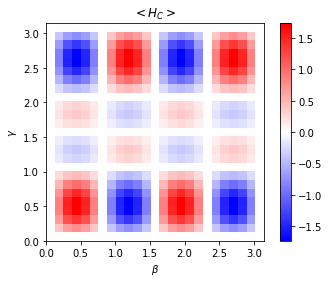

In [18]:
plt.imshow(values, cmap= 'bwr', origin = 'lower', extent=[0, np.pi, 0, np.pi])
plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'$<H_C>$')
plt.show()



## Simulator using qutip and density matrices

Note that I did not actually use density matrices below, given that the state we begin with,pis0, is pure and the evolution is unitary. As such, there is no need to use qutip's mesolve function, and one can simply use qt.expect, with the qubit state and desired operator given as inputs.

However, this could easily be adapted to work with mixed initial states, and superoperators for non-unitary dynamics could also be found.

In [19]:
Zexpectations = []

In [20]:
# Hadamard on everyone
had = hadamard(np.arange(num_qubits))

# Hadamard on everyone but qubit 0
almost_hadamard = hadamard(np.arange(1, num_qubits))

for (gamma, beta) in tqdm(list(itt.product(angle_list, repeat = 2))):
    
    # Dictionary with all qubits but qubit 0 as keys, and gamma as the value
    almost_global_rz_dict = dict.fromkeys(np.arange(1, num_qubits), gamma)
    
    # Rotate qubits around Z axis according to the above dictionary
    almost_rotate_z = rotateZ(almost_global_rz_dict)
    
    # Dictionary with all qubits as keys, and beta as the value
    global_rx_dict = dict.fromkeys(np.arange(num_qubits), beta)
    
    # Initial unitary = I
    operator = qt.identity(sys_dims)
    
    # Apply global Hadamards
    operator = had*operator
    
    # Rotate all but qubit 0 around Z axis by angle gamma
    operator = almost_rotate_z*operator
    
    # Hadamards on everyone but qubit 0
    operator = almost_hadamard*operator
    
    # CZ ladders - the action of the above almost_hadamard, plus the for loop
    # below, is equivalent to a ladder of CNOT's
    for i in range(num_qubits-1):
        operator = Cz(i, i+1)*operator
        operator = hadamard([i+1])*operator
    
    # Mixer term
    operator = rotateX(global_rx_dict)*operator
    
    # If you want the super operator form of the above
    # circuit, it is given by super_operator = qt.to_super(operator)
    
    # State before measurement.
    new_psi = operator*psi0
    
    zz_list = []
    
    
    for i in range(num_qubits-1):
        zz_list.append(sigmaZ([i, i+1]))
    
    # Zexpect is the same as measuring the expectation
    # value of the hamiltonian() above
    Zexpect = sum(qt.expect(zz_list, new_psi))
    
    Zexpectations.append(Zexpect)

100%|████████████████████████████████████████| 625/625 [00:04<00:00, 137.77it/s]


In [21]:
z_values = np.reshape(Zexpectations, [width, width], order = 'C')

In [22]:
print(np.allclose(values, z_values))

True


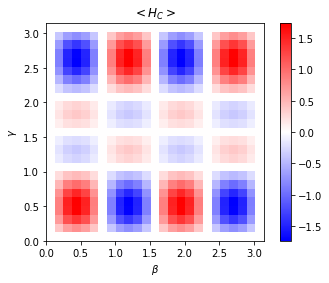

In [23]:
plt.imshow(z_values, cmap= 'bwr', origin = 'lower', extent=[0, np.pi, 0, np.pi])
plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'$<H_C>$')
plt.show()

## Pauli twirling check in the absence of noise

In [24]:
def c(a, b):
    return int(a + b*(3-b)*(3-2*a)/2)

def d(a, b):
    return int(b + a*(3-a)*(3-2*b)/2)

In [25]:
def pauli_op(i, q):
    if i == 0:
        return qt.qeye(sys_dims)
    elif i == 1:
        return sigmaX([q])
    elif i == 2:
        return sigmaY([q])
    elif i == 3:
        return sigmaZ([q])
    else:
        print("You stuffed up, bud.")

In [26]:
number_experiments = 5
random_paulis_for_experiments = np.random.choice([0, 1, 2, 3], size = (number_experiments, 2*num_qubits - 2))

In [27]:
# Hadamard on everyone
had = hadamard(np.arange(num_qubits))

# Hadamard on everyone but qubit 0
almost_hadamard = hadamard(np.arange(1, num_qubits))

twirled_expectations = []

for exp_index, pauli_list in enumerate(random_paulis_for_experiments):
    
    print(f"\rWorking on experiment: {exp_index+1}", end="")
    sys.stdout.flush()
    
    Zexpectations = []
    
    for (gamma, beta) in tqdm(list(itt.product(angle_list, repeat = 2))):
        
        # Dictionary with all qubits but qubit 0 as keys, and gamma as the value
        almost_global_rz_dict = dict.fromkeys(np.arange(1, num_qubits), gamma)
        
        # Rotate qubits around Z axis according to the above dictionary
        almost_rotate_z = rotateZ(almost_global_rz_dict)
        
        # Dictionary with all qubits as keys, and beta as the value
        global_rx_dict = dict.fromkeys(np.arange(num_qubits), beta)
        
        # Initial unitary = I
        operator = qt.identity(sys_dims)
        
        # Apply global Hadamards
        operator = had*operator
        
        # Rotate all but qubit 0 around Z axis by angle gamma
        operator = almost_rotate_z*operator
        
        # Hadamards on everyone but qubit 0
        operator = almost_hadamard*operator
        
        # CZ ladder with twirls
        for i in range(num_qubits-1):
            
            
            # a,b,c,d indices
            a_index = pauli_list[2*i]
            b_index = pauli_list[2*i + 1]
            c_index = c(a_index, b_index)
            d_index = d(a_index, b_index)
            
            
            # Pauli operators
            pauli_a = pauli_op(a_index, i)
            pauli_b = pauli_op(b_index, i + 1)
            pauli_c = pauli_op(c_index, i)
            pauli_d = pauli_op(d_index, i + 1)
            
            
            operator = pauli_a*pauli_b*operator
            
            operator = Cz(i, i+1)*operator
            
            operator = pauli_c*pauli_d*operator
            
            operator = hadamard([i+1])*operator
        
        # Mixer term
        operator = rotateX(global_rx_dict)*operator
        
        # If you want the super operator form of the above
        # circuit, it is given by super_operator = qt.to_super(operator)
        
        # State before measurement
        new_psi = operator*psi0
        
        # Zexpect is the same as measuring the expectation
        # value of the hamiltonian() above
        Zexpect = qt.expect(hamiltonian(), new_psi)

        Zexpectations.append(Zexpect)

    z_values = np.reshape(Zexpectations, [width, width], order = 'C')
    
    twirled_expectations.append(z_values)

Working on experiment: 1

NameError: name 'sys' is not defined

In [ ]:
for item in twirled_expectations:
    print(np.allclose(values, item))

In [ ]:
twirled_average = np.sum(twirled_expectations, axis=0)/number_experiments

print(np.allclose(values, twirled_average))

In [ ]:
plt.imshow(twirled_average, cmap= 'bwr', origin = 'lower', extent=[0, np.pi, 0, np.pi])
plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'$<H_C>$')
plt.show()

## Noise

In [ ]:
def damping_after_dephasing(damp_prob, dephase_prob):
    
    # Damping Kraus operators
    K0damp = qt.Qobj([[1, 0],
                      [0, np.sqrt(1-damp_prob)]])
    K1damp = qt.Qobj([[0, np.sqrt(damp_prob)],
                      [0, 0]])
    
    # Dephasing Kraus operators
    K0deph = qt.Qobj([[np.sqrt(1-dephase_prob), 0],
                      [0, np.sqrt(1-dephase_prob)]])
    K1deph = qt.Qobj([[np.sqrt(dephase_prob), 0],
                      [0, -np.sqrt(dephase_prob)]])
    
    kraus_ops = [K0damp*K0deph, K0damp*K1deph, K1damp*K0deph, K1damp*K1deph]
    return kraus_ops

In [ ]:
prob_damp = 0.4
prob_deph = 0.4

In [ ]:
def kraus_on_single_qubit(j, damp_prob, dephase_prob):
    
    # Returns a list of four operators, corresponding
    # to the four Kraus operators in damping_after_dephasing
    # acting solely on qubit j.

    kraus_list = damping_after_dephasing(damp_prob, dephase_prob)

    listy = []

    for item in kraus_list:
        list_temp = []
        for i in range(num_qubits):
            if i == j:
                list_temp.append(item)
            else:
                list_temp.append(qt.qeye(2))
        listy.append(qt.tensor(list_temp))
    
    return listy

In [ ]:
# kraus_on_single_qubit(0, prob_damp, prob_deph)[0]

In [ ]:
def kraus_on_two_qubits(j1, j2, damp_prob, dephase_prob):
    
    # Returns a list of sixteen operators, corresponding
    # to the four Kraus operators in damping_after_dephasing
    # acting on qubits j1 and j2.
    
    if j1 == j2:
        print("You should probably choose a different pair of qubits to which to apply your Krauses.")
        return None

    kraus_list = damping_after_dephasing(damp_prob, dephase_prob)

    listy = []

    for item1 in kraus_list:
        for item2 in kraus_list:
            list_temp = []
            for i in range(num_qubits):
                if i == j1:
                    list_temp.append(item1)
                elif i == j2:
                    list_temp.append(item2)
                else:
                    list_temp.append(qt.qeye(2))
            listy.append(qt.tensor(list_temp))
    
    return listy

In [ ]:
# kraus_on_two_qubits(0, 1, prob_damp, prob_deph)

In [ ]:
Zexpectations = []

# Hadamard on everyone
had = hadamard(np.arange(num_qubits))

# Hadamard on everyone but qubit 0
almost_hadamard = hadamard(np.arange(1, num_qubits))

for (gamma, beta) in tqdm(list(itt.product(angle_list, repeat = 2))):
    
    # Dictionary with all qubits but qubit 0 as keys, and gamma as the value
    almost_global_rz_dict = dict.fromkeys(np.arange(1, num_qubits), gamma)
    
    # Rotate qubits around Z axis according to the above dictionary
    almost_rotate_z = rotateZ(almost_global_rz_dict)
    
    # Dictionary with all qubits as keys, and beta as the value
    global_rx_dict = dict.fromkeys(np.arange(num_qubits), beta)
    
    # RX(beta) on all qubits
    global_rotate_x = rotateX(global_rx_dict)
    
    # Initial unitary = I
    operator = qt.identity(sys_dims)
    
    # Apply global Hadamards
    operator = had*operator
    
    # Rotate all but qubit 0 around Z axis by angle gamma
    operator = almost_rotate_z*operator
    
    # Hadamards on everyone but qubit 0
    operator = almost_hadamard*operator
    
    # Create density matrix; in the previous simaultions we
    # were able to work with pure states as the evolution of
    # the system was unitary and noiseless. Noise here
    # forces us to use denisty matrix formalism
    
    # Density matrix before CNOTs
    rho = qt.ket2dm(operator*psi0)
    
    for i in range(num_qubits-1):
        
        # CZ
        rho = Cz(i, i+1)*rho*(Cz(i, i+1).dag())
        
        # CZ noise
        rho_temp = qt.qzero(sys_dims)
                
        list_of_two_kraus = kraus_on_two_qubits(i, i+1, prob_damp, prob_deph)
        
        for item in list_of_two_kraus:
            rho_temp = rho_temp + (item*rho*(item.dag()))
        
        rho = rho_temp
        
        rho = hadamard([i+1])*rho*(hadamard([i+1]).dag())
        
    # Global RX(beta) terms
    
    rho = global_rotate_x*rho*(global_rotate_x.dag())
    
    # Zexpect in Sohaib's code is the same as measuring the expectation
    # value of the hamiltonian() above
    
    Zexpect = qt.expect(hamiltonian(), rho)
    
    Zexpectations.append(Zexpect)

z_values = np.reshape(Zexpectations, [width, width], order = 'C')

In [ ]:
plt.imshow(z_values, cmap= 'bwr', origin = 'lower', extent=[0, np.pi, 0, np.pi])
plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'$<H_C>$')
plt.show()

## Twirling with noise

First without the twirling

In [ ]:
number_experiments = 5
random_paulis_for_experiments = np.random.choice([0, 1, 2, 3], size = (number_experiments, 2*num_qubits - 2))

In [ ]:
# Hadamard on everyone
had = hadamard(np.arange(num_qubits))

# Hadamard on everyone but qubit 0
almost_hadamard = hadamard(np.arange(1, num_qubits))

twirled_expectations_noisy = []

for exp_index, pauli_list in enumerate(random_paulis_for_experiments):
    
    print(f"\rWorking on experiment: {exp_index+1}", end="")
    sys.stdout.flush()
    
    Zexpectations_noisy = []
    
    for (gamma, beta) in tqdm(list(itt.product(angle_list, repeat = 2))):
        
        # Dictionary with all qubits but qubit 0 as keys, and gamma as the value
        almost_global_rz_dict = dict.fromkeys(np.arange(1, num_qubits), gamma)
        
        # Rotate qubits around Z axis according to the above dictionary
        almost_rotate_z = rotateZ(almost_global_rz_dict)
        
        # Dictionary with all qubits as keys, and beta as the value
        global_rx_dict = dict.fromkeys(np.arange(num_qubits), beta)
        
        # RX(beta) on all qubits
        global_rotate_x = rotateX(global_rx_dict)
        
        # Initial unitary = I
        operator = qt.identity(sys_dims)
        
        # Apply global Hadamards
        operator = had*operator
        
        # Rotate all but qubit 0 around Z axis by angle gamma
        operator = almost_rotate_z*operator
        
        # Hadamards on everyone but qubit 0
        operator = almost_hadamard*operator
        
        # Density matrix before CNOTs
        rho = qt.ket2dm(operator*psi0)
        
        # CZ ladder
        for i in range(num_qubits-1):
            
            # a,b,c,d indices
            a_index = pauli_list[2*i]
            b_index = pauli_list[2*i + 1]
            c_index = c(a_index, b_index)
            d_index = d(a_index, b_index)
            
            # Pauli operators
            pauli_a = pauli_op(a_index, i)
            pauli_b = pauli_op(b_index, i + 1)
            pauli_c = pauli_op(c_index, i)
            pauli_d = pauli_op(d_index, i + 1)
            
#            pre_twirl = pauli_a*pauli_b
#            rho = pre_twirl*rho*(pre_twirl.dag())
            
            # CZ
            rho = Cz(i, i+1)*rho*(Cz(i, i+1).dag())
            
            # CZ noise
            rho_temp = qt.qzero(sys_dims)
            
            list_of_two_kraus = kraus_on_two_qubits(i, i+1, prob_damp, prob_deph)
            
            for item in list_of_two_kraus:
                rho_temp = rho_temp + (item*rho*(item.dag()))
            
            rho = rho_temp
            
#            post_twirl = pauli_c*pauli_d
#            rho = post_twirl*rho*(post_twirl.dag())
            
            rho = hadamard([i+1])*rho*(hadamard([i+1]).dag())
        
        # Global RX(beta) terms
        
        rho = global_rotate_x*rho*(global_rotate_x.dag())
        
        # Zexpect in Sohaib's code is the same as measuring the expectation
        # value of the hamiltonian() above
        
        Zexpect_noisy = qt.expect(hamiltonian(), rho)
        
        Zexpectations_noisy.append(Zexpect_noisy)
        
    z_values_noisy = np.reshape(Zexpectations_noisy, [width, width], order = 'C')
    
    twirled_expectations_noisy.append(z_values_noisy)

In [ ]:
for item in twirled_expectations_noisy:
    print(np.allclose(z_values, item))

In [ ]:
twirled_noisy_average = np.sum(twirled_expectations_noisy, axis=0)/number_experiments

print(np.allclose(z_values, twirled_noisy_average))

In [ ]:
plt.imshow(twirled_noisy_average, cmap= 'bwr', origin = 'lower', extent=[0, np.pi, 0, np.pi])
plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'$<H_C>$')
plt.show()

Now with twirling

In [ ]:
number_experiments = 20
random_paulis_for_experiments = np.random.choice([0, 1, 2, 3], size = (number_experiments, 2*num_qubits - 2))

In [ ]:
# Hadamard on everyone
had = hadamard(np.arange(num_qubits))

# Hadamard on everyone but qubit 0
almost_hadamard = hadamard(np.arange(1, num_qubits))

twirled_expectations_noisy = []

for exp_index, pauli_list in enumerate(random_paulis_for_experiments):
    
    print(f"\rWorking on experiment: {exp_index+1}", end="")
    sys.stdout.flush()
    
    Zexpectations_noisy = []
    
    for (gamma, beta) in tqdm(list(itt.product(angle_list, repeat = 2))):
        
        # Dictionary with all qubits but qubit 0 as keys, and gamma as the value
        almost_global_rz_dict = dict.fromkeys(np.arange(1, num_qubits), gamma)
        
        # Rotate qubits around Z axis according to the above dictionary
        almost_rotate_z = rotateZ(almost_global_rz_dict)
        
        # Dictionary with all qubits as keys, and beta as the value
        global_rx_dict = dict.fromkeys(np.arange(num_qubits), beta)
        
        # RX(beta) on all qubits
        global_rotate_x = rotateX(global_rx_dict)
        
        # Initial unitary = I
        operator = qt.identity(sys_dims)
        
        # Apply global Hadamards
        operator = had*operator
        
        # Rotate all but qubit 0 around Z axis by angle gamma
        operator = almost_rotate_z*operator
        
        # Hadamards on everyone but qubit 0
        operator = almost_hadamard*operator
        
        # Density matrix before CNOTs
        rho = qt.ket2dm(operator*psi0)
        
        # CZ ladder
        for i in range(num_qubits-1):
            
            # a,b,c,d indices
            a_index = pauli_list[2*i]
            b_index = pauli_list[2*i + 1]
            c_index = c(a_index, b_index)
            d_index = d(a_index, b_index)
            
            # Pauli operators
            pauli_a = pauli_op(a_index, i)
            pauli_b = pauli_op(b_index, i + 1)
            pauli_c = pauli_op(c_index, i)
            pauli_d = pauli_op(d_index, i + 1)
            
            pre_twirl = pauli_a*pauli_b
            rho = pre_twirl*rho*(pre_twirl.dag())
            
            # CZ
            rho = Cz(i, i+1)*rho*(Cz(i, i+1).dag())
            
            # CZ noise
            rho_temp = qt.qzero(sys_dims)
            
            list_of_two_kraus = kraus_on_two_qubits(i, i+1, prob_damp, prob_deph)
            
            for item in list_of_two_kraus:
                rho_temp = rho_temp + (item*rho*(item.dag()))
            
            rho = rho_temp
            
            post_twirl = pauli_c*pauli_d
            rho = post_twirl*rho*(post_twirl.dag())
            
            rho = hadamard([i+1])*rho*(hadamard([i+1]).dag())
        
        # Global RX(beta) terms
        
        rho = global_rotate_x*rho*(global_rotate_x.dag())
        
        # Zexpect in Sohaib's code is the same as measuring the expectation
        # value of the hamiltonian() above
        
        Zexpect_noisy = qt.expect(hamiltonian(), rho)
        
        Zexpectations_noisy.append(Zexpect_noisy)
        
    z_values_noisy = np.reshape(Zexpectations_noisy, [width, width], order = 'C')
    
    twirled_expectations_noisy.append(z_values_noisy)

In [ ]:
twirled_noisy_average = np.sum(twirled_expectations_noisy, axis=0)/number_experiments

print(np.allclose(z_values, twirled_noisy_average))

In [ ]:
plt.imshow(twirled_noisy_average, cmap= 'bwr', origin = 'lower', extent=[0, np.pi, 0, np.pi])
plt.colorbar()
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title(r'$<H_C>$')
plt.show()